<a href="https://colab.research.google.com/github/Vaycold/Python_ML/blob/main/Financial_ML/%EA%B8%88%EC%9C%B5%EB%8D%B0%EC%9D%B4%ED%84%B0(multi_class).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset

   - [US Adult Income] from UCI(https://archieve.jcs.uci.edu/ml/datasets/adult)
   - 위의 기존 데이터에서 변수를 추가함.


    age             : 나이
    workclass       : 직업구분
    education       : 교육수준
    education.num   : 교육수준(numerically coded)
    marital.status  : 혼인상태
    occupation      : 직업
    relationship    : 가족관계
    race            : 인종
    sex             : 성별
    capital.gain    : 자본이득
    capital.loss    : 자본손실
    hours.per.week  : 주당 근로시간
    spending.groc   : 식료품 소비 금액(continuous)
    spending.med    : 병의원 소비 금액(continuous)
    spending.trav   : 여행 레저 소비 금액(continuous)
    income          : 소득 이진구분( Binary )
    income.num      : 소득 금액(continuous)

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [6]:
datapath = 'https://github.com/mchoimis/financialML/raw/main/income/'
data = pd.io.parsers.read_csv(datapath+'income_ext.csv')
print(data.shape)
print(data.columns)

(32561, 19)
Index(['age', 'workclass', 'education', 'education.num', 'marital.status',
       'occupation', 'relationship', 'sex', 'capital.gain', 'capital.loss',
       'hours.per.week', 'spend.groc', 'spend.med', 'spend.trav', 'asset',
       'balance', 'native.country', 'income', 'income.num'],
      dtype='object')


In [7]:
data.head()

,age,workclass,education,education.num,marital.status,occupation,relationship,sex,capital.gain,capital.loss,hours.per.week,spend.groc,spend.med,spend.trav,asset,balance,native.country,income,income.num
0,90,?,HS-grad,9,Widowed,?,Not-in-family,Female,0,4356,40,77053,13687,3478,345498,-36,United-States,0,43713
1,82,Private,HS-grad,9,Widowed,Exec-managerial,Not-in-family,Female,0,4356,18,132870,27294,27567,242642,57638,United-States,0,33113
2,66,?,Some-college,10,Widowed,?,Unmarried,Female,0,4356,40,186061,32029,24506,578403,46028,United-States,0,31652
3,54,Private,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,Female,0,3900,40,140359,22449,23655,229303,7899,United-States,0,55087
4,41,Private,Some-college,10,Separated,Prof-specialty,Own-child,Female,0,3900,40,264663,40863,71439,672614,57675,United-States,0,85583


In [10]:
# Create raw dataset for input
x = data.drop(
    ['education','income','income.num'], axis=1
)
y = data['income.num']

In [11]:
x.head()

,age,workclass,education.num,marital.status,occupation,relationship,sex,capital.gain,capital.loss,hours.per.week,spend.groc,spend.med,spend.trav,asset,balance,native.country
0,90,?,9,Widowed,?,Not-in-family,Female,0,4356,40,77053,13687,3478,345498,-36,United-States
1,82,Private,9,Widowed,Exec-managerial,Not-in-family,Female,0,4356,18,132870,27294,27567,242642,57638,United-States
2,66,?,10,Widowed,?,Unmarried,Female,0,4356,40,186061,32029,24506,578403,46028,United-States
3,54,Private,4,Divorced,Machine-op-inspct,Unmarried,Female,0,3900,40,140359,22449,23655,229303,7899,United-States
4,41,Private,10,Separated,Prof-specialty,Own-child,Female,0,3900,40,264663,40863,71439,672614,57675,United-States


In [12]:
y.head()

0    43713
1    33113
2    31652
3    55087
4    85583
Name: income.num, dtype: int64

In [13]:
# Create Multi-Class
def value_change(x):
    if x <= 10000: return 0
    if x >  10000 and x <= 20000 : return 1
    if x >  20000 and x <= 30000 : return 2
    if x >  30000 and x <= 40000 : return 3
    if x >  40000 and x <= 50000 : return 4
    if x >  50000 and x <= 60000 : return 5
    if x >  60000 and x <= 70000 : return 6
    if x >  70000 and x <= 80000 : return 7
    if x >  80000 and x <= 90000 : return 8
    if x >  90000 and x <= 100000 : return 9
    return 10                          
                                       ## Define function

y = y.apply(lambda x: value_change(x))  ## Apply Lambda function

In [14]:
y.unique()

array([ 4,  3,  5,  8,  7,  9,  2,  6,  1,  0, 10])

In [16]:
y.value_counts()

6     3318
9     3310
7     3276
4     3273
8     3257
1     3250
5     3246
3     3233
2     3180
0     3176
10      42
Name: income.num, dtype: int64

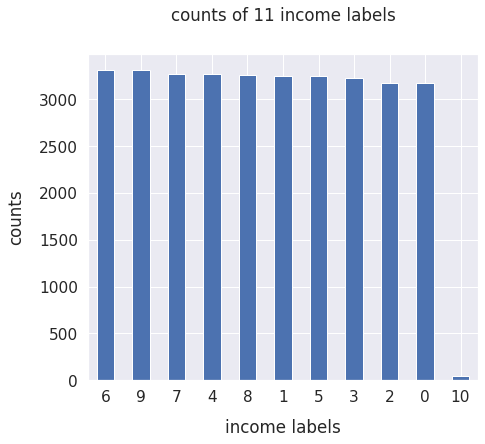

In [19]:
sns.set(font_scale = 1.4)
y.value_counts().plot(kind='bar', figsize=(7,6), rot=0)
plt.xlabel('income labels', labelpad=14)
plt.ylabel('counts',labelpad=14)
plt.title('counts of 11 income labels\n', y=1.02)
plt.show()

In [21]:
# Feature enginerring

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
categorical = ['workclass', 'marital.status', 'occupation', 'relationship', 'sex', 'native.country']
for feature in categorical :
    le = LabelEncoder()
    x_train[feature] = le.fit_transform(x_train[feature])
    x_test[feature] = le.transform(x_test[feature])

In [25]:
x_train[categorical].head()

,workclass,marital.status,occupation,relationship,sex,native.country
32098,7,2,4,5,0,39
25206,2,2,7,0,1,39
23491,4,4,4,1,0,39
12367,2,4,5,3,1,39
7054,1,2,4,0,1,39


## Light GBM 

개요
 


- Decision Tree의 앙상블 모델인 Gradient Boosting Decision Tree (GBDT)는 실무에서 XGboost(eXtreme Gradient Boosting) 등으로도 알려져 있습니다. 각각의 반복에서 GBDT는 음의 기울기(Residual Error)를 적합함으로써 Decision Tree를 학습시키게 됩니다. 


- 그러나 고차원 대용량 데이터에서는 너무 많은 시간의 소모가 발생하였는데, 왜냐하면 모든 가능한 분할점에 대해 정보 획득(information gain)을 평가하기 위해 데이터 전부를 스캔해야 했기 때문입니다. 


- Light GBM은 이러한 Gradient Boosting 모델의 단점을 극복하기 위해 샘플링 등의 기법을 이용하여 <b>스캔하는 데이터 양을 줄임으로써</b> 분석 시간을 획기적으로 단축시킨 방법론입니다.


- LGBM은 <b>범주변수가 많은 정형 데이터</b>와 <b>다중분류</b>에 유용한 알고리즘으로, 간단한 원리를 알아두시면 도움이 될 것입니다.


- 참고링크: Light GBM: A Highly Efficient Gradient Boosting Decision Tree (NIPS 2017)
[https://papers.nips.cc/paper/2017/hash/6449f44a102fde848669bdd9eb6b76fa-Abstract.html ] 

 Light GBM 파라미터 설명

- `objective` : 목적함수, regression, binary, multiclass 가능
- `categorical_feature` : 범주변수임을 선언
- `max_cat_group` : 범주형 변수가 많을 때 과적합을 방지하는 분기 포인트를 찾아서 카테고리 그룹을 max_cat_group 그룹으로 합치고 그룹 경계선에서 분기 포인트를 찾게 됨, 기본값은 64
- `boosting`: 부스팅 방법, 기본값은 gbdt(gradient boosting decision tree)이며 샘플링을 이용하는 goss(Gradient-based One-Side Sampling), 딥러닝의 드롭아웃과 같은 dart (Dropouts meet Multiple Additive Regression Trees), rf (Random Forest) 등의 기법 선택 가능
- `learning_rate` : 학습율, 각 예측기마다 얼마나 가중치를 주어 학습하게 할것인지 결정
- `early_stopping_round` : 더 이상 validation 데이터에서 성능 향상이 없으면 멈추게끔 하는 단위 
- `metric`: loss 측정 기준, binary_logloss, multi_logloss, mae, rmse, auc, cross_entropy 등이 있다

In [26]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
lgbm = LGBMClassifier()
lgbm.fit(x_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
'''

boosting_type='gbdt' 
‘gbdt’, traditional Gradient Boosting Decision Tree. 
‘dart’, Dropouts meet Multiple Additive Regression Trees.
‘goss’, Gradient-based One-Side Sampling.
‘rf’, Random Forest

'''

In [27]:
y_pred = lgbm.predict(x_test)
lgbm_score = accuracy_score(y_test, y_pred)
print('LightGBM Accuracy score : ', round(lgbm_score,4))

LightGBM Accuracy score :  0.8119


In [36]:
pd.DataFrame(y_test).head(10)

,income.num
22278,6
8950,6
7838,7
16505,3
19140,2
12319,7
28589,7
10000,1
28530,3
24237,6


In [35]:
pd.DataFrame(y_pred, columns=['Predict_value']).head(10)

,Predict_value
0,6
1,6
2,7
3,1
4,3
5,7
6,7
7,1
8,3
9,6


In [37]:
# Checking the confusion matrix
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))

[[934  41   4   3   1   0   2   3   0   0   0]
 [ 40 869  46  13   1   0   0   0   0   0   0]
 [ 23  42 807  45   7   0   2   2   0   2   0]
 [ 13  20  75 838  62   6   2   2   1   0   0]
 [ 11  17  16  73 758  70  12   4   5   3   0]
 [  8  13  18  22  76 758  78  12  11   6   0]
 [ 10   7  11  12  11  92 702  78  13  15   0]
 [ 12   8  10   8  11  12  77 730  91  23   0]
 [  7  10  10   6   9   7  12 102 727  88   0]
 [  8   7  10  16  16   6   7  29  62 808   0]
 [  0   0   0   0   0   0   0   0   0  12   0]]


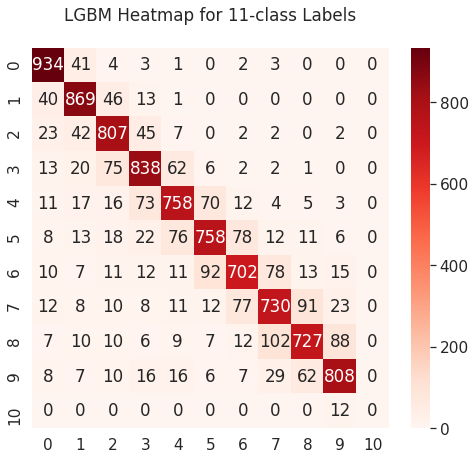

In [38]:
# Heatmap
plt.figure(figsize=(8,7))
sns.heatmap(confusion_matrix(y_test, y_pred),
            cmap = 'Reds',
            annot = True,
            fmt = '.0f')
plt.title('LGBM Heatmap for 11-class Labels\n');

In [41]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91       988
           1       0.84      0.90      0.87       969
           2       0.80      0.87      0.83       930
           3       0.81      0.82      0.82      1019
           4       0.80      0.78      0.79       969
           5       0.80      0.76      0.78      1002
           6       0.79      0.74      0.76       951
           7       0.76      0.74      0.75       982
           8       0.80      0.74      0.77       978
           9       0.84      0.83      0.84       969
          10       0.00      0.00      0.00        12

    accuracy                           0.81      9769
   macro avg       0.74      0.74      0.74      9769
weighted avg       0.81      0.81      0.81      9769



## RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier()
rf.fit()

In [ ]:
print(df.shape)
print(df.columns)

(32561, 15)
Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
       'income'],
      dtype='object')


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [ ]:
# Checking the missing value
# Changing '?' into missing value
df[df=='?'] = np.nan
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [ ]:
# Filling the missing value with mode value

for col in ['workclass','occupation', 'native.country'] :
    df[col].fillna(df[col].mode()[0], inplace = True)
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,Private,77053,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,Private,186061,Some-college,10,Widowed,Prof-specialty,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [ ]:
df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [ ]:
# Feature Engineering
x = df.drop(
    ['income','education','fnlwgt'], axis=1
)
y = df['income']

In [ ]:
x.head()

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,90,Private,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,4356,40,United-States
1,82,Private,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States
2,66,Private,10,Widowed,Prof-specialty,Unmarried,Black,Female,0,4356,40,United-States
3,54,Private,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States
4,41,Private,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States


In [ ]:
y.head()

0    <=50K
1    <=50K
2    <=50K
3    <=50K
4    <=50K
Name: income, dtype: object

In [ ]:
# Spit the raw data into train/test data
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.3, random_state = 0)
x_train.head()

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
32098,40,State-gov,13,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,20,United-States
25206,39,Local-gov,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,38,United-States
23491,42,Private,10,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States
12367,27,Local-gov,9,Never-married,Farming-fishing,Own-child,White,Male,0,0,40,United-States
7054,38,Federal-gov,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States


In [ ]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
       'income'],
      dtype='object')

In [ ]:
# processing the categorical feature
from sklearn.preprocessing import LabelEncoder

categorical = ['workclass','marital.status','occupation','relationship','race','sex','native.country']
for feature in categorical :
    le = LabelEncoder()
    x_train[feature] = le.fit_transform(x_train[feature])
    x_test[feature] = le.transform(x_test[feature])
    
# Method for changing numerically

In [ ]:
x_train[categorical]

,workclass,marital.status,occupation,relationship,race,sex,native.country
32098,6,2,3,5,4,0,38
25206,1,2,6,0,4,1,38
23491,3,4,3,1,4,0,38
12367,1,4,4,3,4,1,38
7054,0,2,3,0,4,1,38
...,...,...,...,...,...,...,...
13123,5,2,4,0,4,1,38
19648,3,2,13,0,4,1,38
9845,3,4,11,2,2,1,38
10799,3,2,3,0,4,1,38


In [ ]:
x_test[categorical]

,workclass,marital.status,occupation,relationship,race,sex,native.country
22278,3,6,11,4,4,0,38
8950,3,4,5,3,4,0,38
7838,3,4,7,1,1,0,39
16505,0,2,9,0,4,1,38
19140,3,2,11,0,4,1,38
...,...,...,...,...,...,...,...
21949,5,2,4,0,4,1,38
26405,3,2,11,0,4,1,38
23236,3,4,9,3,4,1,38
26823,3,4,6,4,2,0,38


In [ ]:
# 범주변수의 처리
# -1. 클래스를 숫자로 변환 -> Numerically 
# -2. one-hot-encoding

In [ ]:
# Scaling the feature

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns = x.columns)
x_test_scaled = pd.DataFrame(scaler.transform(x_test), columns = x.columns)

In [ ]:
x_train_scaled

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,0.101484,2.600478,1.133894,-0.402341,-0.782234,2.214196,0.392980,-1.430470,-0.145189,-0.217407,-1.662414,0.262317
1,0.028248,-1.884720,-0.423425,-0.402341,-0.026696,-0.899410,0.392980,0.699071,-0.145189,-0.217407,-0.200753,0.262317
2,0.247956,-0.090641,-0.034095,0.926666,-0.782234,-0.276689,0.392980,-1.430470,-0.145189,-0.217407,-0.038346,0.262317
3,-0.850587,-1.884720,-0.423425,0.926666,-0.530388,0.968753,0.392980,0.699071,-0.145189,-0.217407,-0.038346,0.262317
4,-0.044989,-2.781760,1.523223,-0.402341,-0.782234,-0.899410,0.392980,0.699071,-0.145189,-0.217407,-0.038346,0.262317
...,...,...,...,...,...,...,...,...,...,...,...,...
22787,3.763293,1.703439,-0.034095,-0.402341,-0.530388,-0.899410,0.392980,0.699071,-0.145189,-0.217407,-0.038346,0.262317
22788,-0.191461,-0.090641,-0.423425,-0.402341,1.736225,-0.899410,0.392980,0.699071,-0.145189,-0.217407,-0.038346,0.262317
22789,-0.923823,-0.090641,-0.812755,0.926666,1.232533,0.346032,-1.963453,0.699071,-0.145189,-0.217407,0.854891,0.262317
22790,0.394429,-0.090641,1.523223,-0.402341,-0.782234,-0.899410,0.392980,0.699071,-0.145189,-0.217407,-0.038346,0.262317


In [ ]:
x_test_scaled

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,1.273263,-0.090641,-1.980744,2.255673,1.232533,1.591474,0.392980,-1.430470,-0.145189,-0.217407,-0.038346,0.262317
1,-1.436476,-0.090641,-0.423425,0.926666,-0.278542,0.968753,0.392980,-1.430470,-0.145189,-0.217407,-1.256397,0.262317
2,-1.143531,-0.090641,-0.034095,0.926666,0.225150,-0.276689,-3.141670,-1.430470,-0.145189,-0.217407,-0.444363,0.427425
3,-0.118225,-2.781760,1.133894,-0.402341,0.728841,-0.899410,0.392980,0.699071,-0.145189,-0.217407,-0.038346,0.262317
4,0.760610,-0.090641,1.523223,-0.402341,1.232533,-0.899410,0.392980,0.699071,-0.145189,-0.217407,0.773687,0.262317
...,...,...,...,...,...,...,...,...,...,...,...,...
9764,-0.118225,1.703439,-0.423425,-0.402341,-0.530388,-0.899410,0.392980,0.699071,-0.145189,-0.217407,0.773687,0.262317
9765,-0.923823,-0.090641,-0.423425,-0.402341,1.232533,-0.899410,0.392980,0.699071,-0.145189,-0.217407,-0.038346,0.262317
9766,-0.997059,-0.090641,-0.034095,0.926666,0.728841,0.968753,0.392980,0.699071,-0.145189,-0.217407,-0.038346,0.262317
9767,-0.337933,-0.090641,-0.423425,0.926666,-0.026696,1.591474,-1.963453,-1.430470,-0.145189,-0.217407,0.611281,0.262317


## Logistic Classifier

In [ ]:
# Linear Classifier
# [Original Data]
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg = LogisticRegression()
logreg.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred = logreg.predict(x_test)
logreg_score = accuracy_score(y_test, y_pred)

print('Logistic Regression score : ',round(logreg_score,4))

Logistic Regression score :  0.8057


In [ ]:
# [Scaled Data]

logreg = LogisticRegression()
logreg.fit(x_train_scaled, y_train)
y_pred = logreg.predict(x_test_scaled)
logreg_score = accuracy_score(y_test, y_pred)
print('Logistic Regression score : ',round(logreg_score,4))

Logistic Regression score :  0.8222


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       <=50K       0.84      0.94      0.89      7410
        >50K       0.71      0.44      0.55      2359

    accuracy                           0.82      9769
   macro avg       0.78      0.69      0.72      9769
weighted avg       0.81      0.82      0.81      9769



## Randomforest 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_pred = rf.predict(x_test)
rf_score = accuracy_score(y_test, y_pred)
print('RandomForest Classifier Accuracy score : ', round(rf_score,4))

RandomForest Classifier Accuracy score :  0.8483


In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[6847  563]
 [ 919 1440]]


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       <=50K       0.88      0.92      0.90      7410
        >50K       0.72      0.61      0.66      2359

    accuracy                           0.85      9769
   macro avg       0.80      0.77      0.78      9769
weighted avg       0.84      0.85      0.84      9769



## Boosting

In [ ]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=0)
gb.fit(x_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
y_pred = gb.predict(x_test)
gb_score = accuracy_score(y_test, y_pred)
print('Gradient Boosting Accuracy Score : ', round(gb_score,4))
print('\n')
print(classification_report(y_test, y_pred))

Gradient Boosting Accuracy Score :  0.8621


              precision    recall  f1-score   support

       <=50K       0.88      0.95      0.91      7410
        >50K       0.78      0.59      0.68      2359

    accuracy                           0.86      9769
   macro avg       0.83      0.77      0.79      9769
weighted avg       0.86      0.86      0.86      9769



In [ ]:
# LightGBM
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(random_state=0)
lgbm.fit(x_train, y_train)
y_pred = lgbm.predict(x_test)
lgbm_score = accuracy_score(y_test, y_pred)

print('LGBM Accuracy Score : ', round(lgbm_score,4))
print('\n')
print(classification_report(y_test, y_pred))

LGBM Accuracy Score :  0.8677


              precision    recall  f1-score   support

       <=50K       0.89      0.94      0.91      7410
        >50K       0.77      0.65      0.70      2359

    accuracy                           0.87      9769
   macro avg       0.83      0.79      0.81      9769
weighted avg       0.86      0.87      0.86      9769



## Multiclassification